## Load data and calculate coefficients

In [1]:
import os
import sys
sys.path.append("../") # go to parent dir
import glob
import time
import pathlib
import logging
import numpy as np
from mpi4py import MPI
comm = MPI.COMM_WORLD
from scipy.sparse import linalg as spla
from dedalus.tools.config import config
from simple_sphere import SimpleSphere, TensorField, TensorSystem
import equations
import matplotlib.pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs
from dedalus.extras import plot_tools
import logging
from mpl_toolkits import mplot3d
logger = logging.getLogger(__name__)
from matplotlib.animation import FFMpegWriter

#add path to data folder
input_folder = "/Users/Rohit/Documents/research/active_matter_spheres/scripts/data/sphere107"
output_folder = "/Users/Rohit/Documents/research/active_matter_spheres/scripts/garbage"
Omega = 50 #set the Omega
first_frame = 1
last_frame = len(glob.glob1("".join([input_folder,'/']),"*.npz"))
dpi = 256
fields = ['v_ph']

# Setup output folder
if comm.rank == 0:
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
comm.barrier()

t_arr = np.zeros(last_frame)


In [2]:
for ind in range(first_frame, last_frame + 1, 1):
    if np.mod(ind,100)==0: logger.info('Frame:%i'%(ind))
    
    with np.load(os.path.join(input_folder, 'output_%i.npz' %(ind))) as file:
        if ind == first_frame + comm.rank:
            phi = file['phi']
            theta = file['theta']
            L_max = len(theta)-1
            S_max = 4
            simplesphere = SimpleSphere(L_max, S_max)
            omega = TensorField(simplesphere, rank=0)
            coeffs_all = np.zeros((last_frame,L_max+1, L_max+1), dtype=complex)

        om = file['om']
        time = file['t'][0]
        t_arr[ind-1] = time


    # assign loaded data
    omega.component_fields[0]['g'] = om
    # spectral transform
    omega.forward_phi()
    omega.forward_theta()
    coeffs = omega.coeffs
    
    #coeff1[ind-1] = coeffs[m_1][ell_1-m_1]
    #coeff2[ind-1] = coeffs[m_2][ell_2-m_2]
    for m in range(len(coeffs)):
        coeffs_all[ind-1, m, m:] = coeffs[m]

2019-07-16 10:48:17,382 __main__ 0/1 INFO :: Frame:100
2019-07-16 10:48:17,990 __main__ 0/1 INFO :: Frame:200
2019-07-16 10:48:18,605 __main__ 0/1 INFO :: Frame:300


### Check the amplitude of the largest $\ell$ modes

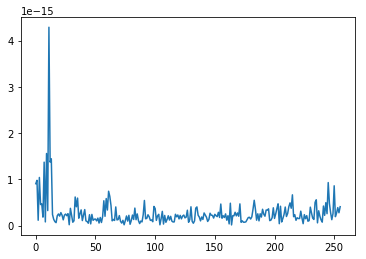

In [56]:
plt.plot(np.arange(0,256,1), np.abs(coeffs_all[-1, :, -1]))

## Find the max of the field 

In [3]:
fields = ['om']
max_vals = {key: 0 for key in fields}
clims = {key: 0 for key in fields}
for field in fields:
    for i in range(first_frame + comm.rank, last_frame + 1, comm.size):
        if np.mod(i,100)==0: logger.info('Frame:%i'%(i))
            
        with np.load("".join([input_folder, '/output_%i.npz' %i])) as file:
            fieldval = file[field]
            max_vals[field] = max(max_vals[field], np.max(fieldval))

for field in fields:
    clims[field] = 0.75*max_vals[field]

2019-07-16 10:48:21,798 __main__ 0/1 INFO :: Frame:100
2019-07-16 10:48:21,934 __main__ 0/1 INFO :: Frame:200
2019-07-16 10:48:22,059 __main__ 0/1 INFO :: Frame:300


## Plot the vorticity and coefficients

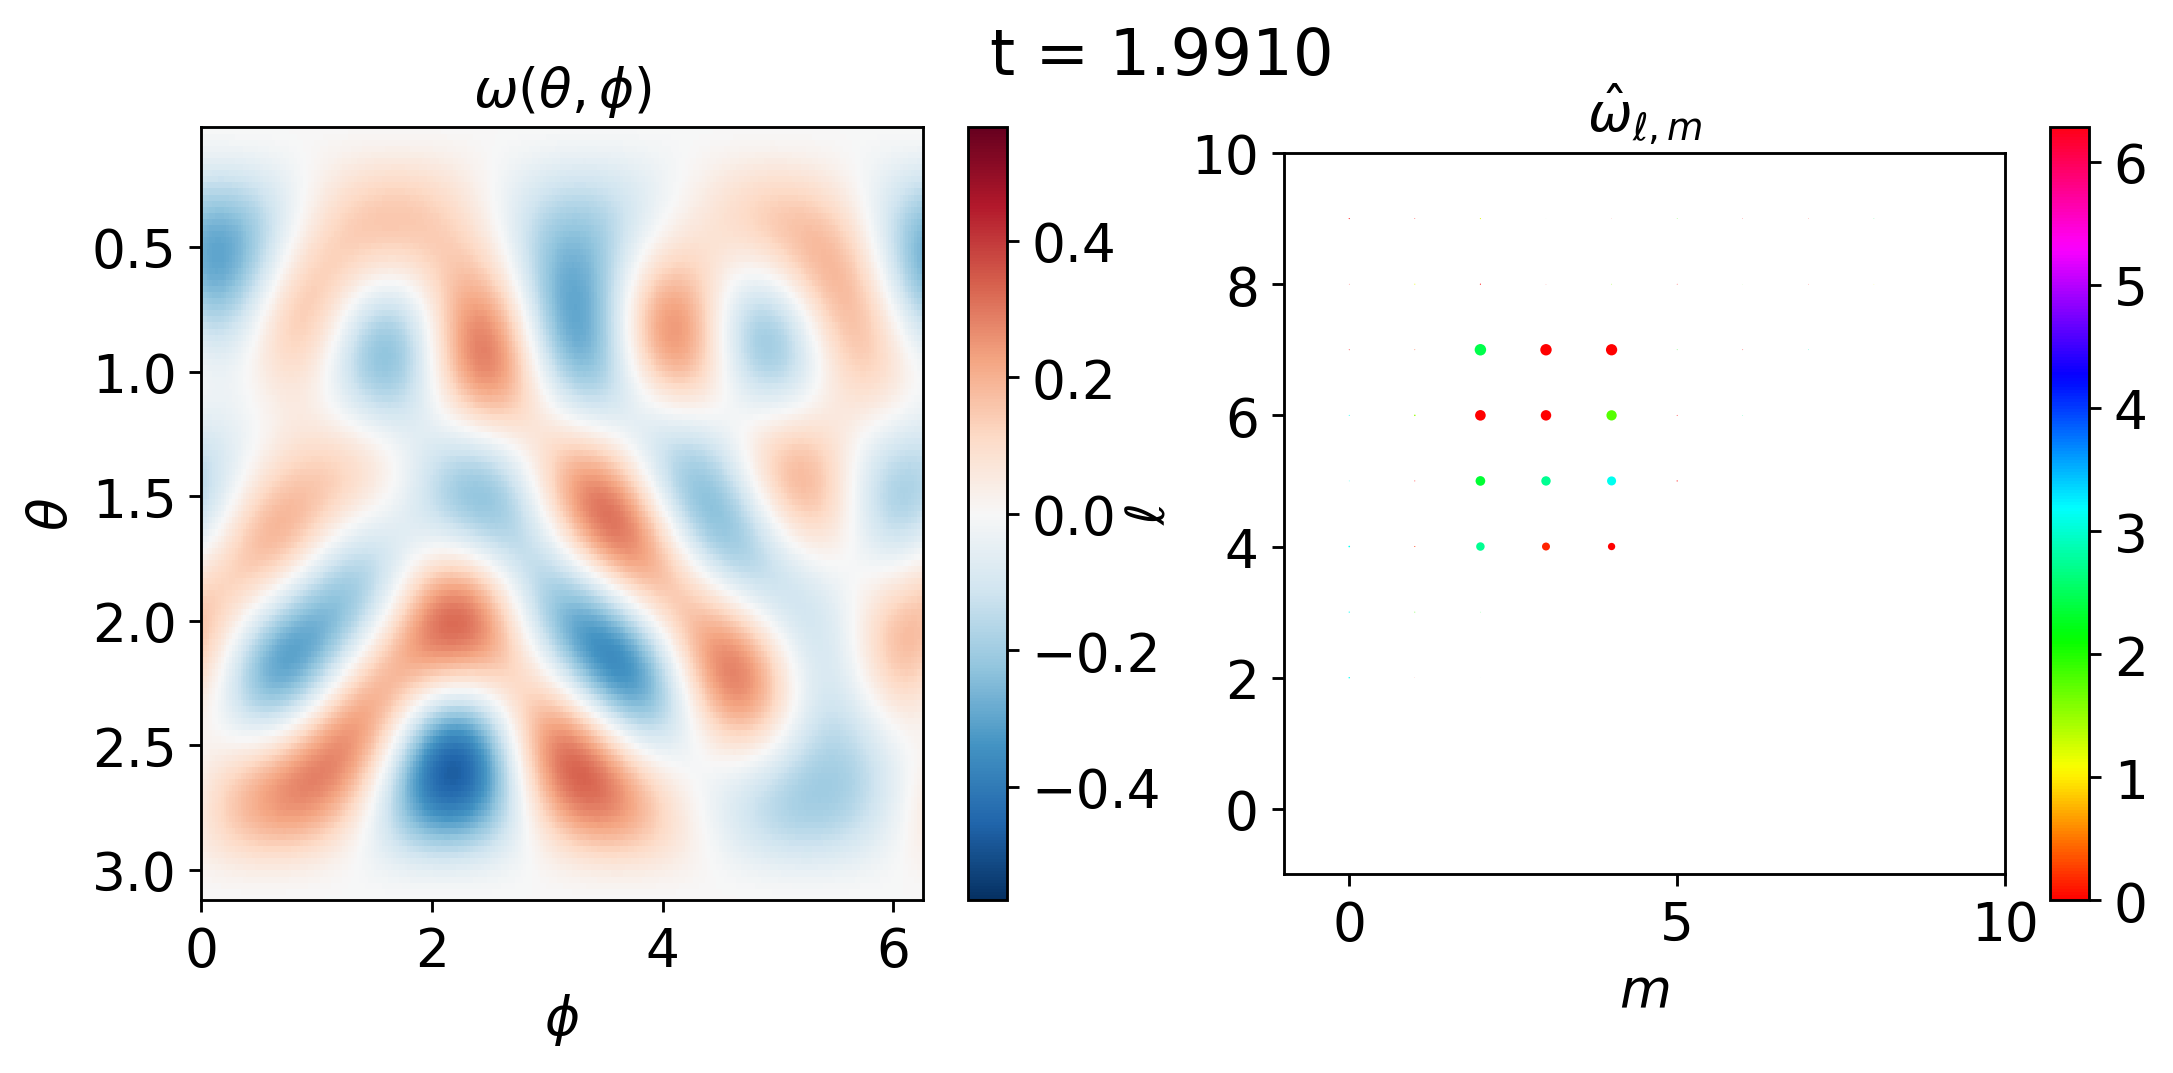

In [10]:
fig, ax = plt.subplots(1,2,figsize=(10, 4), dpi=dpi)
fig.subplots_adjust(hspace=.4)
#plotting
plt.rc('font', size=15)

ind = 200
ell_max = 10 #for plotting

with np.load(os.path.join(input_folder, 'output_%i.npz' %(ind))) as file:
    phi = file['phi']
    theta = file['theta']
    L_max = len(theta)-1
    S_max = 4
    om = file['om']
    time = file['t'][0]


m = np.arange(0,L_max+1)
ell = np.arange(0,L_max+1)
ellell, mm = np.meshgrid(ell, m)

coeffs_arr = coeffs_all[ind, :, :]

mag = np.abs(coeffs_arr)
phase = np.angle(coeffs_arr)

title = fig.suptitle('t = %.4f' %time)

image0 = ax[0].pcolormesh(phi, theta, om.T, cmap='RdBu_r')
ax[0].set_ylabel("$\\theta$"), ax[0].set_xlabel("$\phi$")
ax[0].set_title("$\omega (\\theta, \phi)$",fontsize=15)
ax[0].invert_yaxis()
fig.colorbar(image0, ax=ax[0])
image0.set_clim(-clims['om'], clims['om'])

image1 = ax[1].scatter(mm.flatten(), ellell.flatten(), 200*mag.flatten(), c=phase.flatten(), cmap='hsv', edgecolor='none')
ax[1].set_xlim(-1, ell_max), ax[1].set_ylim(-1, ell_max)
ax[1].set_xlabel('$m$'), ax[1].set_ylabel('$\ell$')
ax[1].set_title('$\hat{\omega}_{\ell, m}$',fontsize=15)
ax[1].set_aspect('equal')
image1.set_clim(0, 2*np.pi)
fig.colorbar(image1, ax=ax[1])


## Find the phase speed of the coefficients

In [33]:
dt = t_arr[2] - t_arr[1]
phase_speed = np.zeros_like(coeffs_all)
phase = np.zeros_like(coeffs_all)
m = np.arange(0,L_max+1)
ell = np.arange(0,L_max+1)
ellell, mm = np.meshgrid(ell, m)

thresh = 1e-1

for ind in range(len(t_arr)):
    if np.mod(ind+1,100)==0: logger.info('Frame:%i'%(ind+1))
    if ind != len(t_arr)-1:
        coeffs_der = (coeffs_all[ind+1, :, :] - coeffs_all[ind, :, :])/dt
        Amp = 0.5*(np.abs(coeffs_all[ind, :, :]) + np.abs(coeffs_all[ind+1, :, :]))
    else: 
        coeffs_der = (coeffs_all[ind, :, :] - coeffs_all[ind-1, :, :])/dt
        Amp = 0.5*(np.abs(coeffs_all[ind, :, :]) + np.abs(coeffs_all[ind-1, :, :]))

    phase[ind, :, :] = np.angle(coeffs_all[ind,:,:])
    phase_speed[ind, :, :] = np.imag(np.conj(coeffs_all[ind,:,:])*coeffs_der/(Amp**2))/mm
    #phase_speed[ind,:, 15:] = np.nan
    #phase_speed[ind,:, :9] = np.nan
    
    #inds = np.where(Amp < thresh)
    #(phase_speed[ind, :, :])[inds] = np.nan
    
    


2019-07-16 11:05:20,513 __main__ 0/1 INFO :: Frame:100


/Users/Rohit/anaconda3/envs/dedalus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


2019-07-16 11:05:20,636 __main__ 0/1 INFO :: Frame:200
2019-07-16 11:05:20,763 __main__ 0/1 INFO :: Frame:300


In [55]:
mean_phase_speed = np.real(np.nanmean(phase_speed[:, :, :], axis=0))
np.nanmean(mean_phase_speed*ellell*(ellell+1))

/Users/Rohit/anaconda3/envs/dedalus/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


99.81807193702548

(0.5, 1.5)

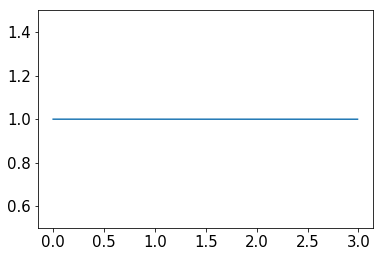

In [56]:
m0 = 3
ell0 = 7
mean_phase_speed[m0,ell0]/(2*Omega/(ell0*(ell0+1)))
plt.plot(t_arr, phase_speed[:,m0,ell0]/(2*Omega/(ell0*(ell0+1))))
plt.ylim([0.5, 1.5])

/Users/Rohit/anaconda3/envs/dedalus/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


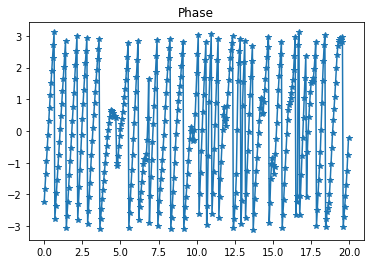

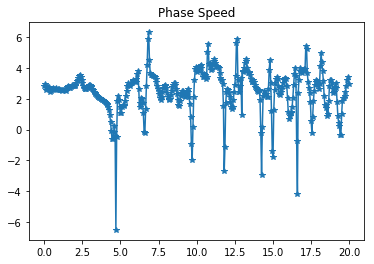

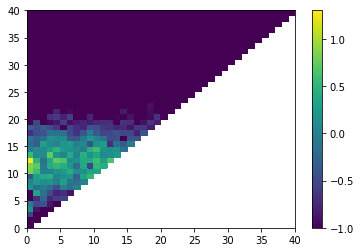

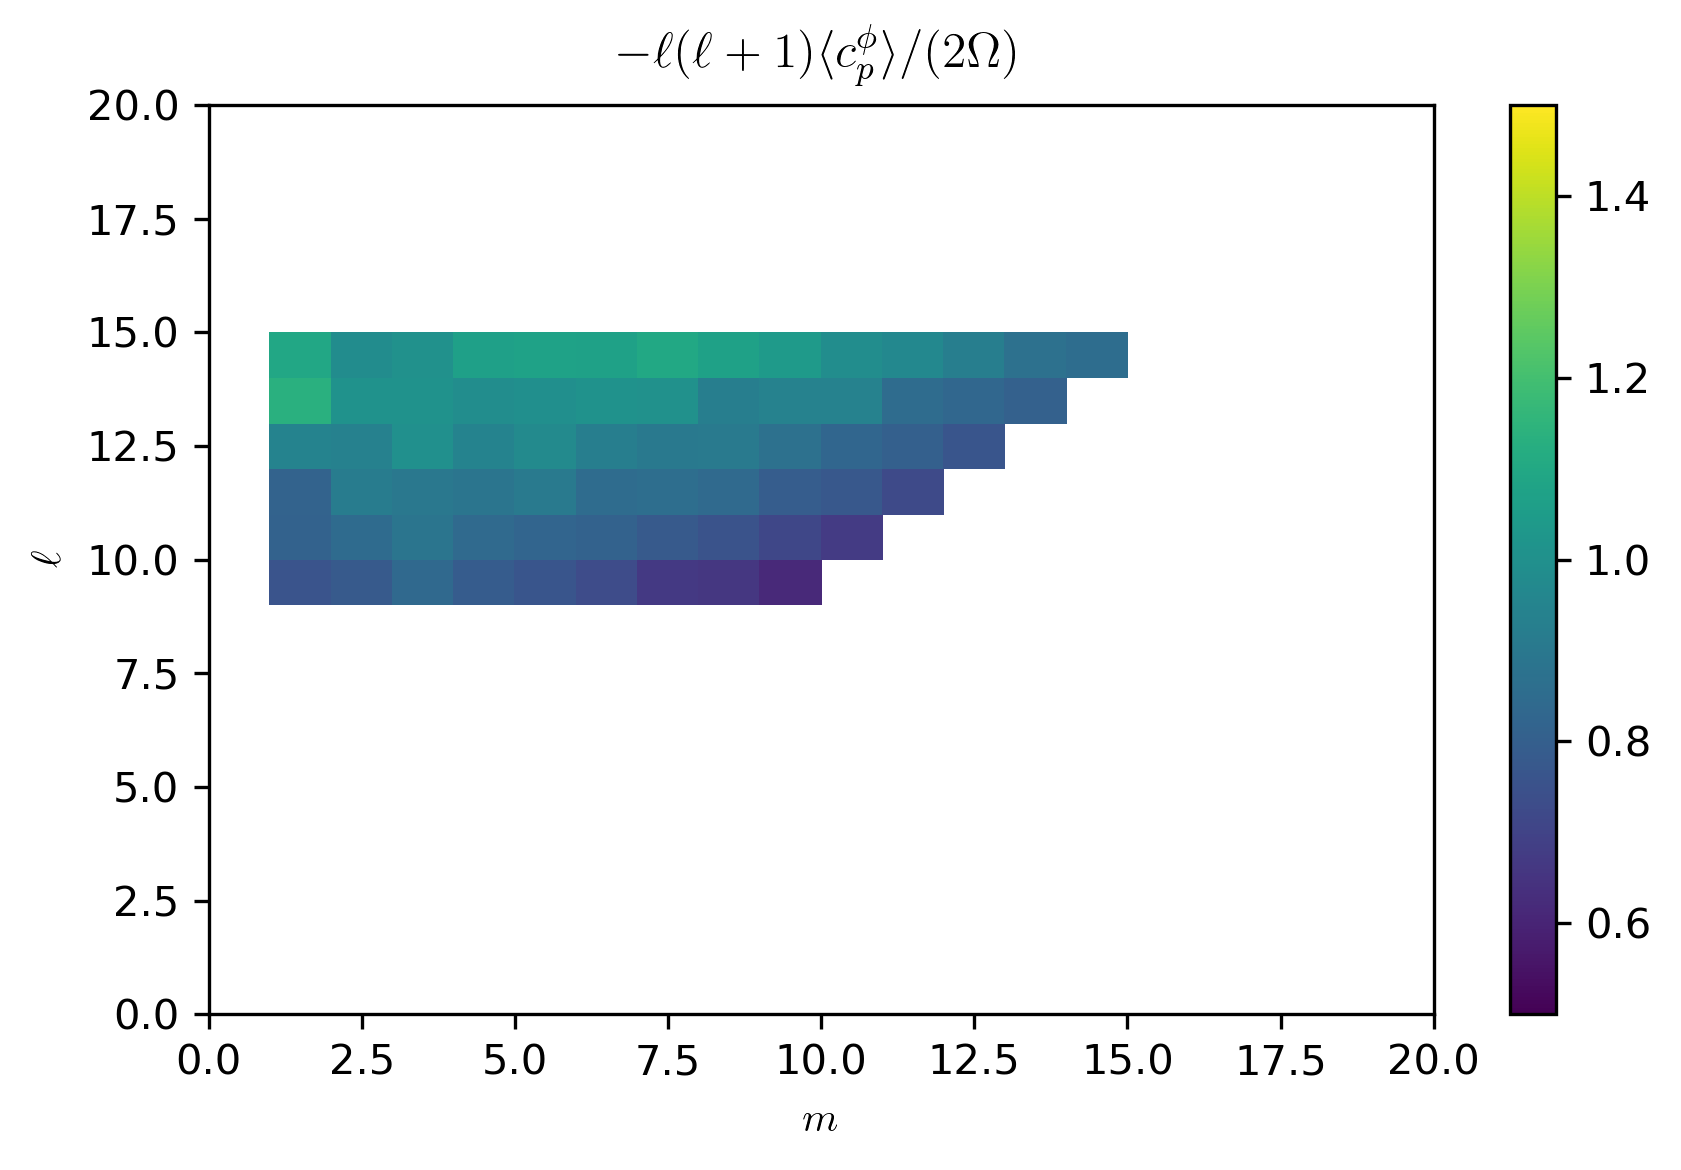

In [100]:
plt.plot(t_arr[:400], phase[:400, 3, 10], '*-'); plt.title('Phase')
plt.figure()
plt.plot(t_arr[:400], phase_speed[:400, 3, 10], '*-'); plt.title('Phase Speed')

plt.figure()
plt.pcolormesh(mm, ellell, np.log10(Amp), vmin=np.log10(thresh))
plt.colorbar()
plt.xlim([0,40]); plt.ylim([0,40])

plt.figure(dpi=300)
plt.pcolormesh(mm, ellell, np.real(mean_phase_speed)*ellell*(ellell+1)/(2*Omega), vmin=0.5, vmax=1.5)
plt.xlim([0,20]); plt.ylim([0,20])
plt.colorbar(); plt.title(r'$-\ell (\ell +1) \langle c_p^\phi \rangle/(2 \Omega)$', usetex=True)
plt.xlabel(r'$m$', usetex=True); plt.ylabel(r'$\ell$', usetex=True)
plt.tight_layout()
plt.savefig('phase_speed_modes_Omega=%i.png' %(Omega))

## Time delay embedding - 2D 

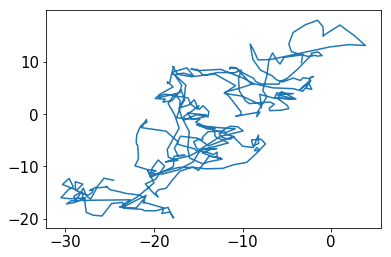

In [6]:
lag = 10 #in terms of time
start_t = 30

dt = t_arr[2]-t_arr[1]
ind_start = int(np.floor(start_t/dt))
lag_inds = int(np.floor(lag/dt))
ell = 11

plt.plot(np.real(coeffs_all[ind_start-lag_inds:-lag_inds, 0, ell]), np.real(coeffs_all[ind_start:, 0, ell]))

## Time delay embedding - 3D


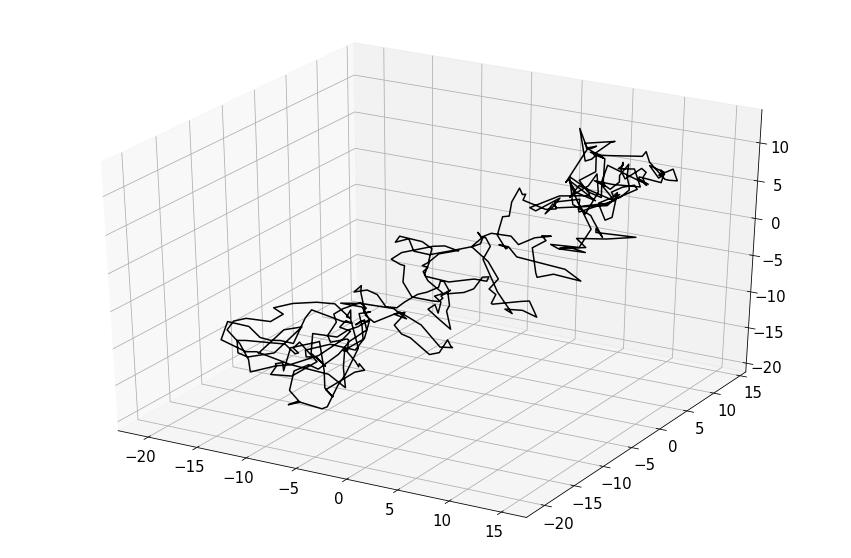

In [8]:
lag = 1 #in terms of time
start_t = 30

dt = t_arr[2]-t_arr[1]
ind_start = int(np.floor(start_t/dt))
lag_inds = int(np.floor(lag/dt))
ell = 13

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
xline = np.real(coeffs_all[ind_start-2*lag_inds:-2*lag_inds, 0, ell])
yline = np.real(coeffs_all[ind_start-1*lag_inds:-1*lag_inds, 0, ell])
zline = np.real(coeffs_all[ind_start:, 0, ell])

ax.plot3D(xline, yline, zline, 'k')

## Plot DFT of the modes 

/Users/Rohit/anaconda3/envs/dedalus/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


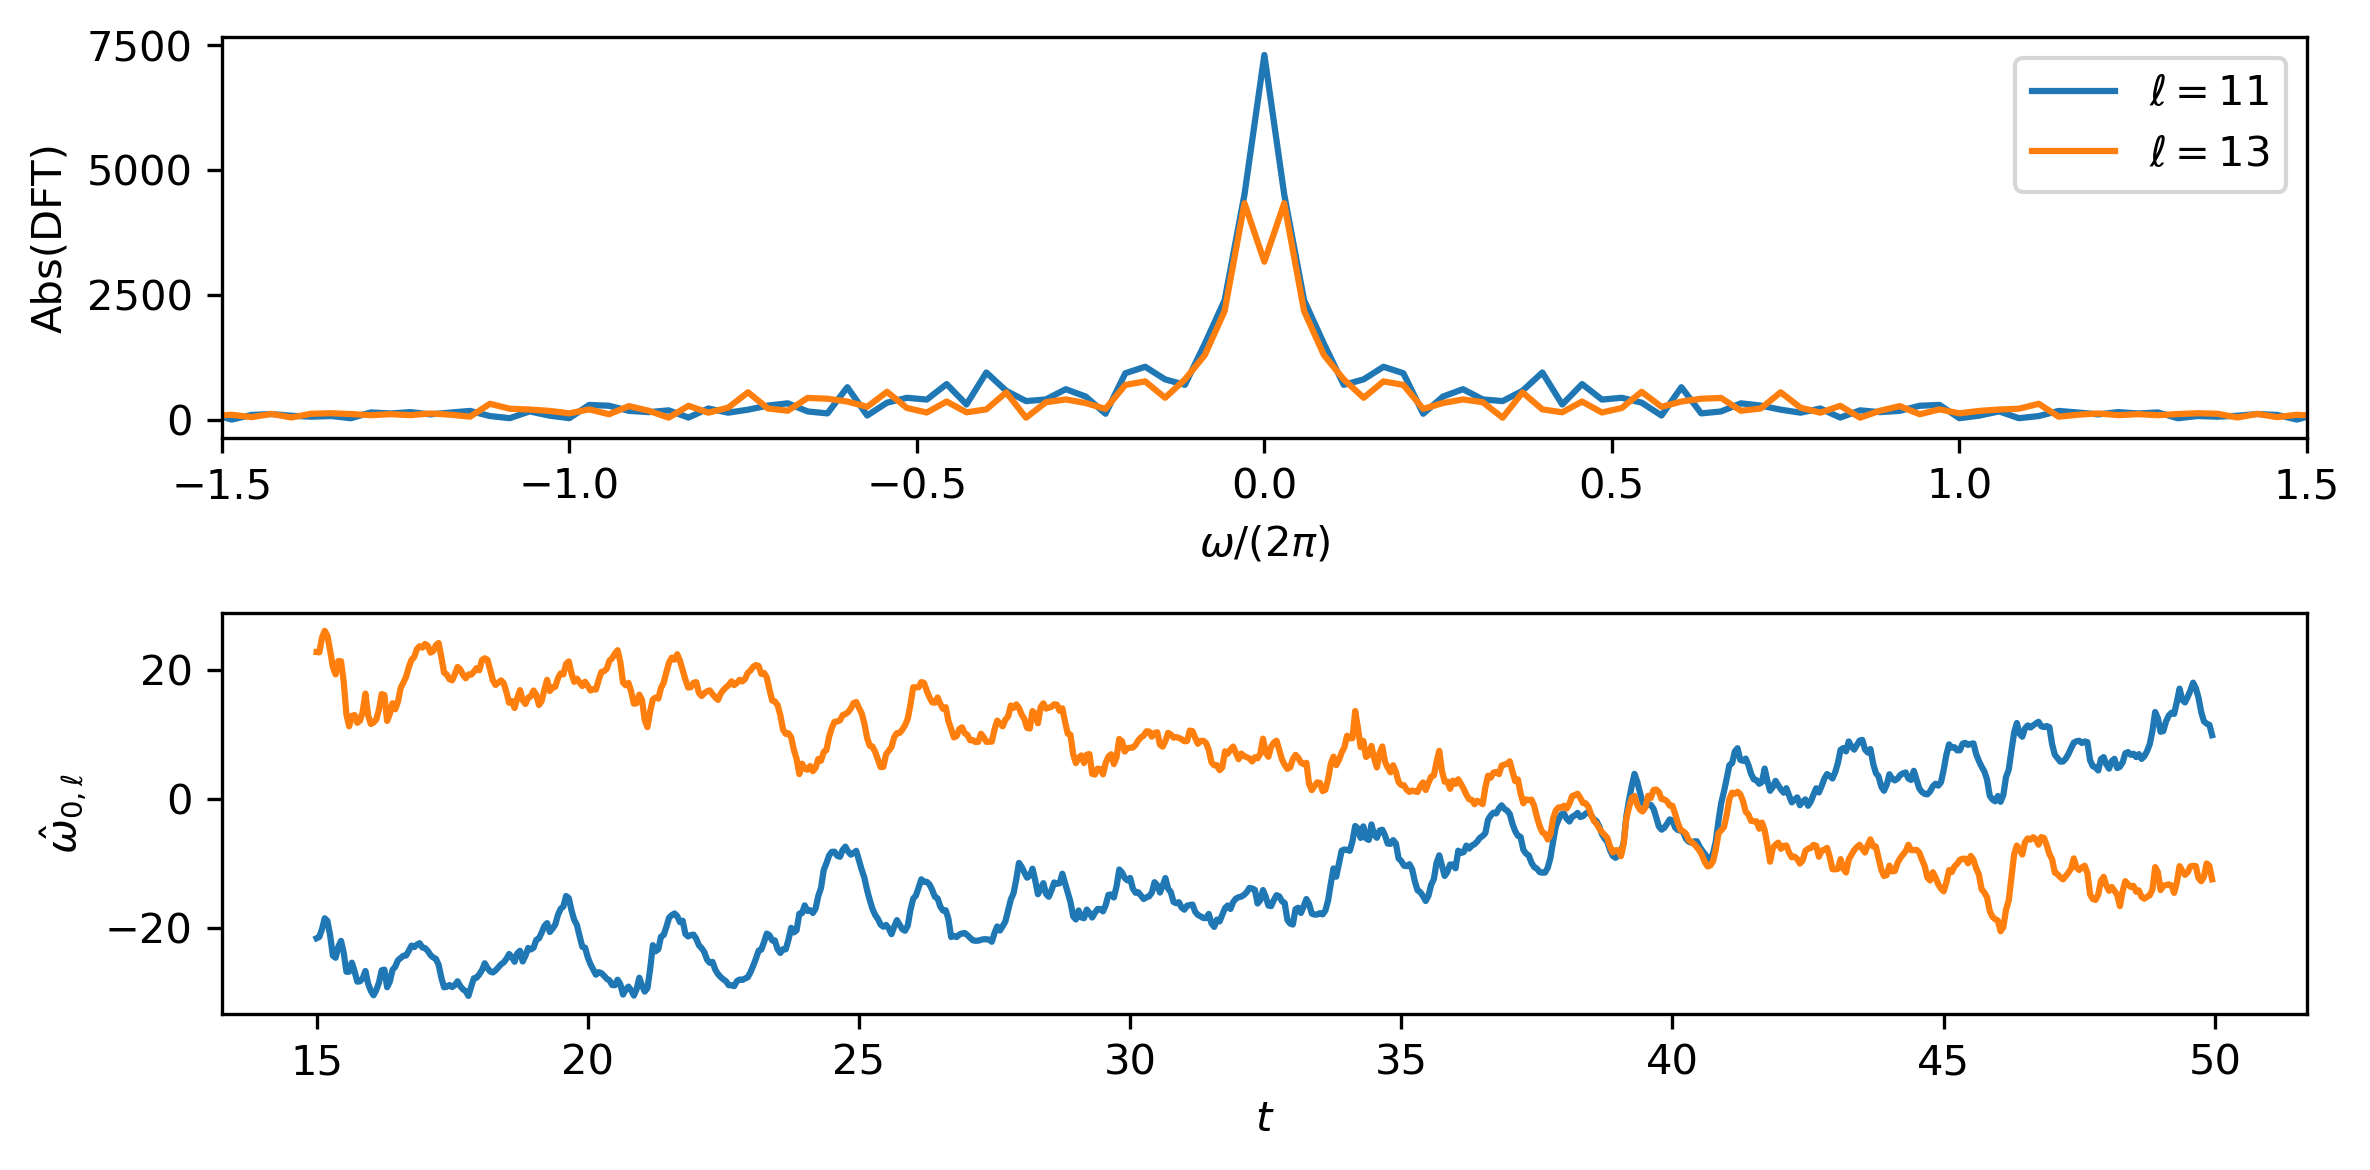

In [9]:
%matplotlib inline
ell_1, m1 = 11, 0
ell_2, m2 = 13, 0

inds = range(300, len(t_arr))

#remove mean 
#signal1 = coeffs_all[inds,m1,ell_1] - np.mean(coeffs_all[inds,m1,ell_1])
signal1 = coeffs_all[inds,m1,ell_1]

om_fft1 = np.fft.fftshift(np.fft.fft(signal1))
#signal2 = coeffs_all[inds,m2,ell_2] - np.mean(coeffs_all[inds,m2,ell_2])
signal2 = coeffs_all[inds,m2,ell_2] 

om_fft2 = np.fft.fftshift(np.fft.fft(signal2))

freq = np.fft.fftshift(np.fft.fftfreq(t_arr[inds].shape[-1], d = t_arr[2]-t_arr[1]))

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,4), dpi=300)
ax1.plot(freq, np.abs(om_fft1))
ax1.plot(freq, np.abs(om_fft2))
ax1.set_xlim([-1.5, 1.5])
#ax.set_ylim([0, 5])
ax1.set_ylabel('Abs(DFT)')
ax1.set_xlabel(r'$\omega/(2\pi)$')
ax1.legend([r'$\ell=11$', r'$\ell=13$'])

ax2.plot(t_arr[inds], signal1)
ax2.plot(t_arr[inds], signal2)
ax2.set_ylabel(r'$\hat{\omega}_{0,\ell}$')
ax2.set_xlabel(r'$t$')

fig.tight_layout() 
plt.savefig('DFT_sphere3.eps')



## Plot KE vs time

### $E(t) = \frac{1}{2} \sum_{m, \ell} \ell (\ell + 1)\left|\hat{\psi}_{m,\ell}(t)\right|^2 = \frac{1}{2} \sum_{m, \ell \neq 0} \frac{\left|\hat{\omega}_{m, \ell}(t)\right|^2}{\ell (\ell +1)}$

In [11]:
E = np.zeros(t_arr.shape)
L_max = len(theta)-1

Emodes = np.zeros(t_arr.shape)

#calculate energy 
for m in range(L_max+1):
    for ell in range(L_max+1):
        if ell!=0:
            E = E + (np.abs(coeffs_all[:,m,ell])**2)/(ell*(ell+1))
    

Text(0, 0.5, 'Energy')

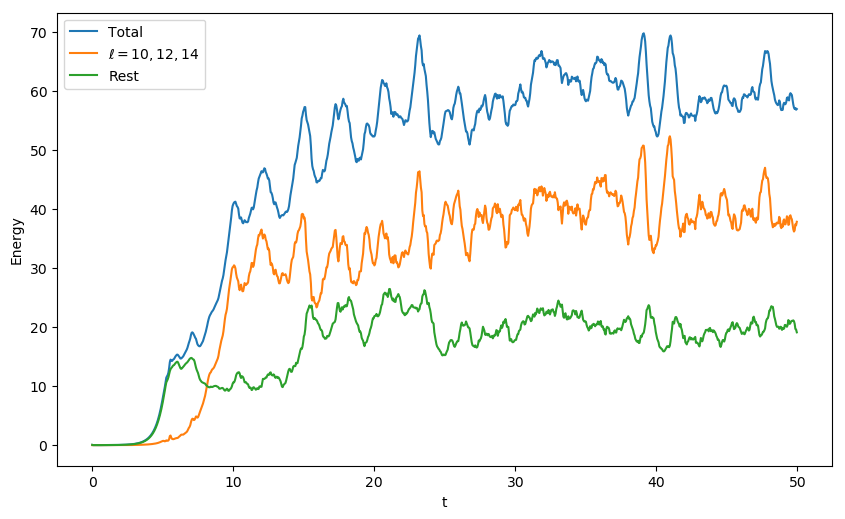

In [17]:
ell1 = 10
ell2 = 12
ell3 = 14
Emodes = np.abs(coeffs_all[:,0,ell1])**2/(ell1*(ell1+1)) + np.abs(coeffs_all[:,0,ell2])**2/(ell2*(ell2+1)) + np.abs(coeffs_all[:,0,ell3])**2/(ell3*(ell3+1))
fig = plt.figure(figsize=(10,6), dpi=100)
plt.plot(t_arr, E)
plt.plot(t_arr, Emodes)
plt.plot(t_arr, E-Emodes)
plt.legend(['Total', r'$\ell = 10, 12, 14$', 'Rest'])

plt.xlabel('t')
plt.ylabel('Energy')
#plt.savefig('energy_sphere3.eps')


## 0-1 test for chaos
Check the hypothesis that dynamics are chaotic about the $\ell = 11$ or $\ell = 13$ modes. 

## $c \in (0, \pi): \\
p_c(n) = \sum_{j=1}^{n} \phi(j) \cos jc, \qquad q_c(n) = \sum_{j=1}^{n} \phi(j) \sin jc \\
M_c(n) = \frac{1}{N} \sum_{j=1}^{N} \left([p_c(j+n) - p_c(j)]^2 + [q_c(j+n) - q_c(j)]^2 \right) $

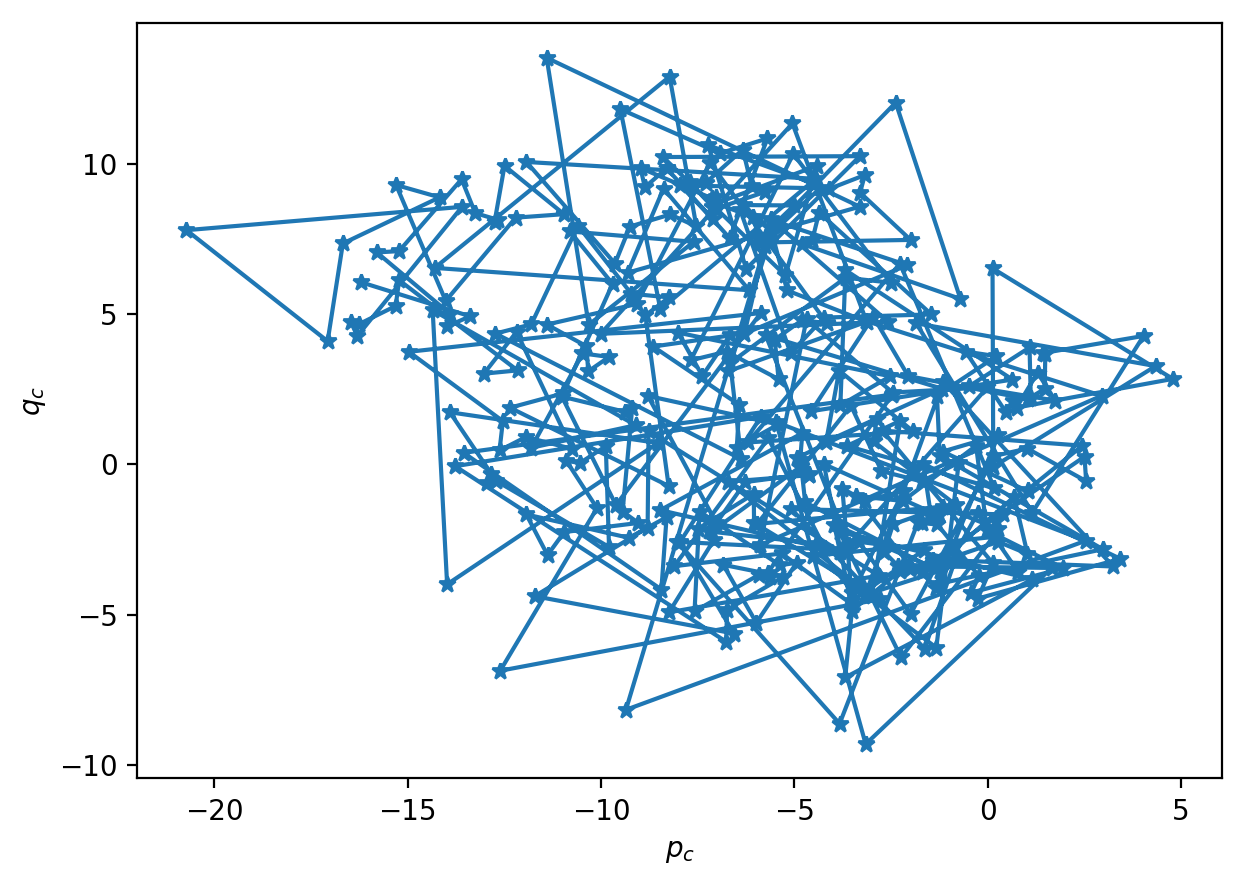

In [116]:
c = np.pi/5 + (3*np.pi/5)*np.random.random_sample()
ell = 13

inds = range(200, len(t_arr),5)
signal = coeffs_all[inds,0,ell] - np.mean(coeffs_all[inds,0,ell])

p = np.cumsum(signal*np.cos(c*np.arange(1,len(signal)+1)))
q = np.cumsum(signal*np.sin(c*np.arange(1,len(signal)+1)))

plt.figure(figsize=(7,5), dpi=200)
plt.plot(p,q, '*-')
plt.xlabel(r'$p_c$')
plt.ylabel(r'$q_c$')
plt.savefig('phase_map.eps')

/Users/Rohit/anaconda3/envs/dedalus/lib/python3.6/site-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys


0.40693529552715885


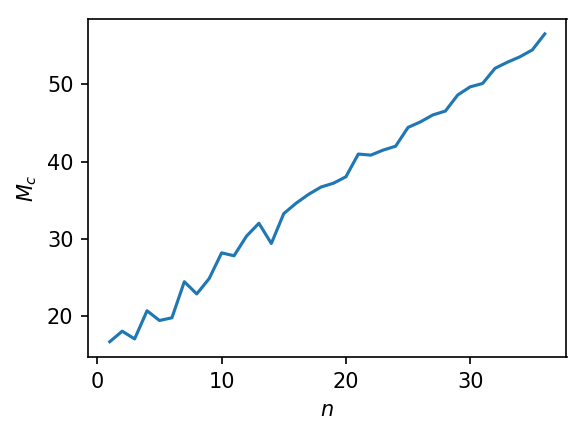

In [117]:
N = len(signal)
N0 = int(np.floor(N/10))

Mc = np.zeros(N0)

for n in range(1, N0+1):
    Mc[n-1] = np.sum((p[n:]-p[0:-n])**2 + (q[n:]-q[0:-n])**2)/(N-n)
    
Vosc = (np.mean(signal))**2 *(1 - np.cos(c*np.arange(1, N0+1)))/(1 - np.cos(c))
Dc = Mc - Vosc

plt.figure(figsize=(4,3), dpi=150)
plt.plot(np.arange(1,N0+1),Mc)
plt.xlabel(r'$n$'); plt.ylabel(r'$M_c$')
plt.tight_layout() 

plt.savefig('Mc_sphere3.eps')

#find Kc
Kc = np.polyfit(np.log(np.arange(1,N0+1)), np.log(Mc), 1)[0]
print(Kc)


### Sweep through all the c's

In [118]:
c_arr = np.linspace(0,np.pi,1000)
inds = range(200, len(t_arr), 10)
Kc_reg = np.zeros(c_arr.shape)
Kc_corr = np.zeros(c_arr.shape)

ell = 11
signal = coeffs_all[inds,0,ell] - np.mean(coeffs_all[inds,0,ell])


for i in range(len(c_arr)):
    c = c_arr[i]

    p = np.cumsum(signal*np.cos(c*np.arange(1,len(signal)+1)))
    q = np.cumsum(signal*np.sin(c*np.arange(1,len(signal)+1)))
    
    N = len(signal)
    N0 = int(np.floor(N/10))
    Mc = np.zeros(N0)

    for n in range(1, N0+1):
        Mc[n-1] = np.sum((p[n:]-p[0:-n])**2 + (q[n:]-q[0:-n])**2)/(N-n)
    
    Kc_reg[i] = np.polyfit(np.log(np.arange(1,N0+1)), np.log(Mc), 1)[0]
    Kc_corr[i] = np.corrcoef(np.arange(1,N0+1), Mc)[0,1]


/Users/Rohit/anaconda3/envs/dedalus/lib/python3.6/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part


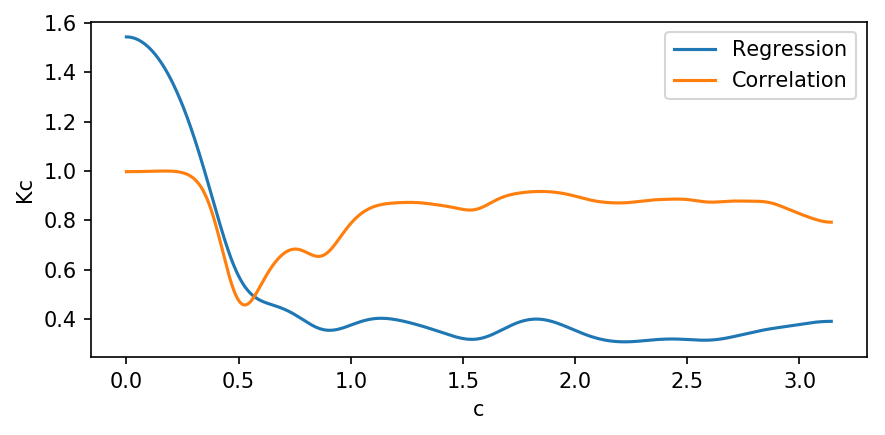

In [119]:
fig = plt.figure(figsize=(6,3), dpi=150)

plt.plot(c_arr, Kc_reg)
plt.plot(c_arr, Kc_corr)
plt.xlabel('c')
plt.ylabel('Kc')
plt.legend(['Regression', 'Correlation'])
plt.tight_layout()
plt.savefig('Kc.eps')

## Plot the time-average of the coefficients

In [1]:
nt, nm, nell = coeffs_all.shape
coeffs_avg = np.zeros([nm, nell])

start_t = 50
end_t = 100

dt = t_arr[2]-t_arr[1]
ind_start = int(np.floor(start_t/dt))
ind_end = int(np.floor(end_t/dt))

t_smooth = 5
f_smooth = np.ones(int(np.floor(t_smooth/dt)))/np.floor(t_smooth/dt)

coeffs_avg = np.mean(np.abs(coeffs_all[ind_start:ind_end, :, :]), axis=0)

mag = np.abs(coeffs_avg)
phase = np.angle(coeffs_avg)

m = np.arange(0,L_max+1)
ell = np.arange(0,L_max+1)
ellell, mm = np.meshgrid(ell, m)

fig = plt.figure(figsize=(5,3), dpi=150)
ell_max = 20

image1 = plt.scatter(mm.flatten(), ellell.flatten(), 2*mag.flatten(), c=phase.flatten(), cmap='hsv', edgecolor='none')
plt.xlim(-1, ell_max); plt.ylim(-1, ell_max)
plt.xlabel('$m$'); plt.ylabel('$\ell$')
plt.title('$\hat{\omega}_{\ell, m}$',fontsize=15)
#plt.aspect('equal')
image1.set_clim(0, 2*np.pi)
fig.colorbar(image1)

NameError: name 'coeffs_all' is not defined